In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

TEXT_COL = "Text"
LABEL_COL = "Category"

X_train_data = pd.read_csv("train_40k.csv")
X_test_data = pd.read_csv("test_10k.csv")

X_train = X_train_data[TEXT_COL].to_numpy()
y_train = X_train_data[LABEL_COL].to_numpy()
X_test = X_test_data[TEXT_COL].to_numpy()
y_test = X_test_data[LABEL_COL].to_numpy()

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 40000, Test size: 10000


In [3]:
from pathlib import Path

def load_stopwords(path):
    # 兼容常见编码 & 去空行/注释/重复
    for enc in ("utf-8", "utf-8-sig", "gbk", "latin-1"):
        try:
            text = Path(path).read_text(encoding=enc)
            break
        except Exception:
            continue
    words = set()
    for line in text.splitlines():
        w = line.strip()
        if not w or w.startswith("#"):
            continue
        words.add(w)
    return words

stopwords = load_stopwords("stopwords.txt")
print(f"Loaded {len(stopwords)} stopwords.")
print(stopwords)


Loaded 891 stopwords.
{'nevertheless', 'seems', 'auth', 'sub', 'f', 'et', 'however', 'biol', 'significantly', 'j', 'facts', 'even', 'older', 'relatively', 'upon', 'n', 'during', 'whom', 'cannot', "'re", 'shall', 'well', 'using', 'adj', 'thousand', 'date', 'throughout', 'anything', 'id', 'goods', 'overall', "it'd", 'causes', 'section', 'used', 'room', 'says', 'secondly', 'able', 'furthers', 'onto', 'would', 'nothing', 'x', "there've", 'couldnt', 'sides', 'very', "aren't", 'shows', 'taken', "he's", 'itself', 'regards', 'backs', 'until', 'thats', 'okay', 'shes', 'her', 'wells', 'somehow', 'these', 'herein', 'case', 'myself', 'sent', 'indicates', 'you', 'sec', 'get', 'potentially', 'ours', 'my', 'either', 'self', 'line', 'showns', 'whether', 'invention', 'knows', 'beforehand', 'own', 'formerly', 'million', 'open', 'where', 'certainly', 'sees', 'therere', 'younger', "'ll", 'comes', 'also', 'newest', 'becomes', 'awfully', 'work', 'himself', 'presents', 'adopted', 'appropriate', "shouldn't", 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
vectorizer = tfidf.fit_transform(X_train)
# print(vectorizer)
# print(X_train[0])
wordlist = tfidf.get_feature_names_out()
print(wordlist)

# df= pd.DataFrame(vectorizer.T.todense(),index=wordlist)
# print(df)


['00' '000' '0000' ... 'zzz' 'zzzzzz' 'zzzzzzzzzz']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

tfidf = TfidfVectorizer()
clf = LinearSVC()
pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", clf)
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

acc  = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred, average="macro", zero_division=0)
rec  = recall_score(y_test, pred, average="macro", zero_division=0)

print(f"基线模型 - 准确率: {acc:.4f} | 精准率(macro): {prec:.4f} | 召回率(macro): {rec:.4f}")
print("\n分类报告\n", classification_report(y_test, pred, zero_division=0))


基线模型 - 准确率: 0.8072 | 精准率(macro): 0.7982 | 召回率(macro): 0.7937

分类报告
                       precision    recall  f1-score   support

       baby products       0.64      0.70      0.67       698
              beauty       0.84      0.80      0.82      2135
grocery gourmet food       0.79      0.78      0.78       840
health personal care       0.77      0.81      0.79      2992
        pet supplies       0.92      0.82      0.87      1576
          toys games       0.83      0.86      0.84      1759

            accuracy                           0.81     10000
           macro avg       0.80      0.79      0.80     10000
        weighted avg       0.81      0.81      0.81     10000



In [6]:
feature_grid = [100, 500, 1000, 2000, 5000, 10000, 20000, 40000]  # None 表示不限制特征数量
results = []

for mfeat in feature_grid:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            min_df=2,
            max_features=mfeat,
            stop_words="english"   # 中文改为 None
        )),
        ("clf", LinearSVC())
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    acc  = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, pred, average="macro", zero_division=0)

    results.append({
        "max_features": "All" if mfeat is None else mfeat,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec
    })

res_df = pd.DataFrame(results)
display(res_df)


,max_features,accuracy,precision_macro,recall_macro
0,100,0.5309,0.567875,0.459321
1,500,0.6756,0.683867,0.649657
2,1000,0.7295,0.726092,0.705674
3,2000,0.7562,0.750504,0.737805
4,5000,0.7758,0.768576,0.762462
5,10000,0.7854,0.774833,0.769151
6,20000,0.7959,0.789398,0.780065
7,40000,0.8027,0.797241,0.787339


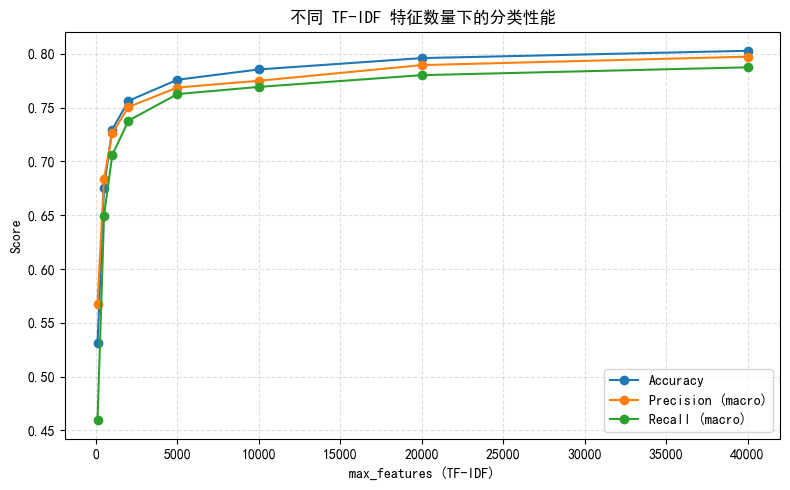

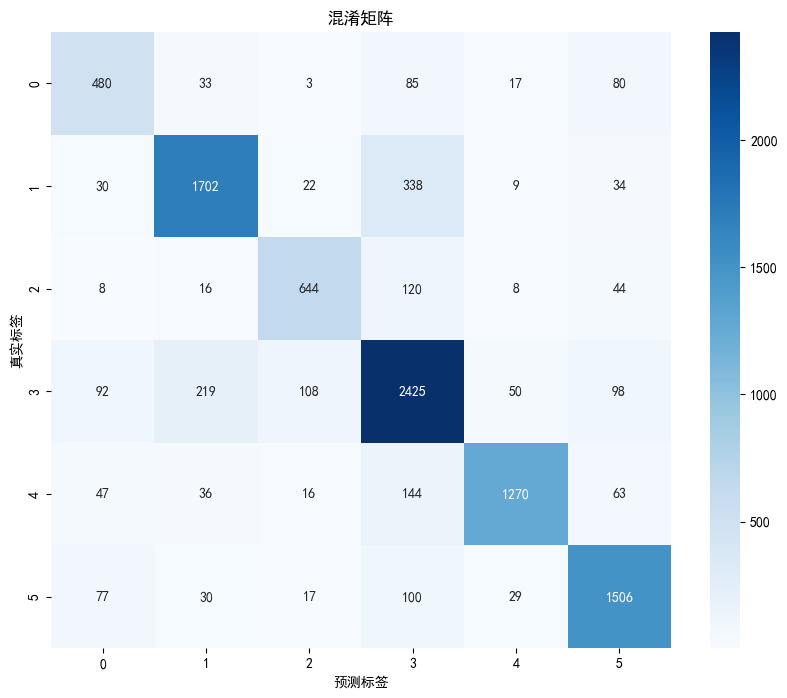

In [7]:
plt.figure(figsize=(8,5))
x = [r["max_features"] for r in results]
accs  = [r["accuracy"] for r in results]
precs = [r["precision_macro"] for r in results]
recs  = [r["recall_macro"] for r in results]

plt.plot(x, accs, marker="o", label="Accuracy")
plt.plot(x, precs, marker="o", label="Precision (macro)")
plt.plot(x, recs, marker="o", label="Recall (macro)")
plt.xlabel("max_features (TF-IDF)")
plt.ylabel("Score")
plt.title("不同 TF-IDF 特征数量下的分类性能")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 添加F1-score和混淆矩阵
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# 计算F1-score
f1 = f1_score(y_test, pred, average="macro")

# 绘制混淆矩阵
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()